In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from netCDF4 import Dataset as netcdf_dataset
import numpy as np
from obspy import UTCDateTime
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature
import os
import dynamic_yaml
with open("config.yml", 'r') as f:
    configs = dynamic_yaml.load(f)
video = True
import warnings
warnings.filterwarnings('ignore')
from ww32seismo import *

In [4]:
work_dir = configs.params.work_dir#"/home/raph/WORK/WAVEWATCH/MUNICH"
os.environ["CARTOPY_USER_BACKGROUNDS"] = "{}/BG".format(work_dir)

In [6]:
import cmasher as cmr
cmap = cmr.cosmic    # CMasher
cmap = plt.get_cmap('cmr.cosmic')   # MPL

In [3]:
def read_p2ls(year, months, p2l_dir):
    times = []
    p2ls = []
    for month in [1]:
        fname = r"%s/LOPS_WW3-GLOB-30M_%i%02i_p2l.nc"%(p2l_dir, year, month)
        dataset = netcdf_dataset(fname)

        lats = dataset.variables['latitude'][:]
        lons = dataset.variables['longitude'][:]
        currtimes = dataset.variables['time'][:]
        freqs = dataset.variables['f'][:]
        df = np.diff(freqs)
        df = np.append(df[0],df)
        for i, t in enumerate(currtimes):
            mask = dataset.variables['p2l'][i, 0, : , :].mask
            p2l = np.sum([(10**(dataset.variables['p2l'][i, fi, : , :]-1e-12))*df[fi] for fi in range(len(df))], axis=0) #Already in Pa2m2s?, sum all freqs
            p2ls.append(np.ma.array(p2l, mask=mask))
            times.append(t)
    return times, p2ls

In [8]:
#TODO use os.path.join for windows compatibility

year = configs.download.year
#p2l_dir =  "/home/raph/WORK/SEISMOSTORM/{}/FIELD_NC".format(year)
p2l_dir = os.path.join(work_dir,"DATA", "P2L", "{}".format(year), "FIELD_NC")#"{}/DATA/P2L/{}/FIELD_NC".format(work_dir,year)
#months = [1] # Lit of the months numerical values, #TODO get it from configs
months = configs.download.months

times, p2ls, lats, lons = read_p2ls(year, months, p2l_dir)

Done reading the P2L file(s)


# Check the spread of the values

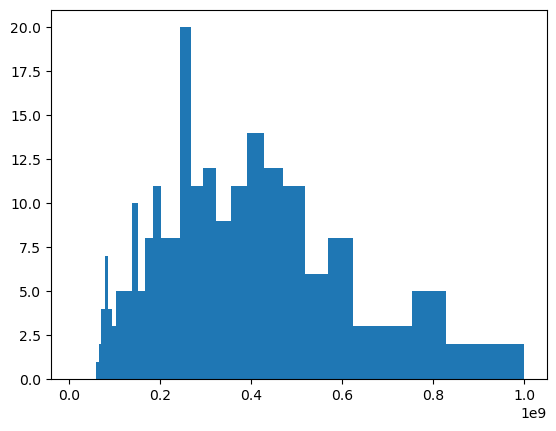

In [9]:
#%matplotlib inline
plt.style.use('default')
ptps = [a.ptp() for a in p2ls]
plt.figure()
plt.hist(ptps, bins=np.logspace(7,9,50))
plt.savefig(os.path.join(work_dir,"FIGURES","histogram.png"))
#plt.show()

In [10]:
def animate(i):
    """
    Animates the P2L maps to generate a GIF/video
    """
    quad.set_array(p2ls[i])
    title = (UTCDateTime("1990-01-01")+times[i]*86400).strftime("%Y-%m-%d %Hh")
    ax.title.set_text(title)


# Global scale map

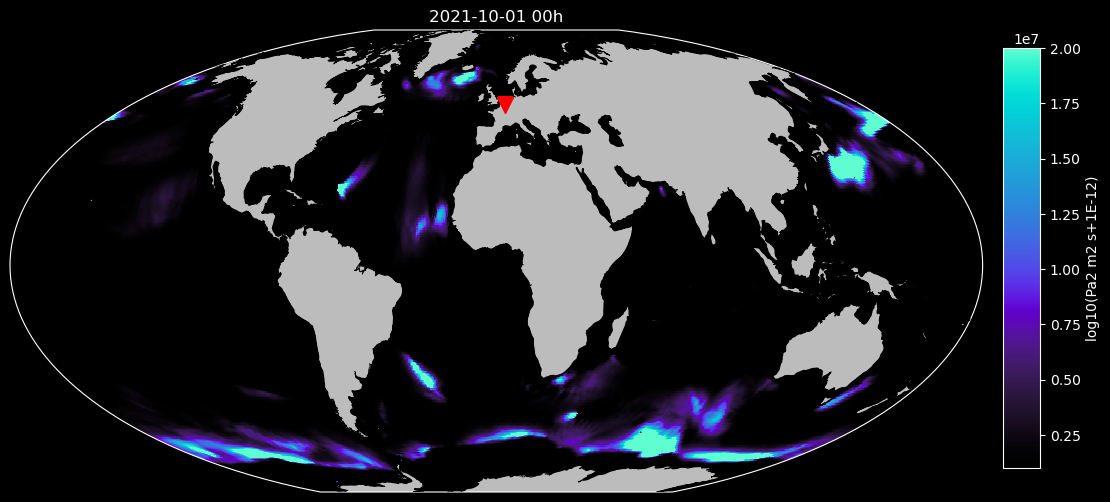

In [20]:
plt.style.use('dark_background')
xmin = -180
xmax = 180
ymin = -90
ymax = 90
vmax = 7

#cmap = "magma"#"cubehelix_r"
cmap = plt.get_cmap('cmr.cosmic')

target_lat = configs.params.station_lat
target_lon = configs.params.station_lon



fig = plt.figure(figsize=(15, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ax.coastlines(resolution='50m', linewidth=0.5, zorder=9, color="k")

ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor="#bcbcbc", zorder = 2)

quad = plt.pcolormesh(lons, lats, p2ls[0], transform=ccrs.PlateCarree(),vmin=1e5, vmax=0.2e8, cmap=cmap)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
cb = fig.colorbar(quad, cax=cbar_ax)    
cb.set_label("log10(Pa2 m2 s+1E-12)")

#ax.set_xlim(xmin, xmax)
#ax.set_ylim(ymin, ymax)
ax.plot(target_lon, target_lat, "rv",markersize=12, zorder =10, transform=ccrs.PlateCarree())

title = (UTCDateTime("1990-01-01")+times[0]*86400).strftime("%Y-%m-%d %Hh")
ax.set_title(title, color="w")
plt.tight_layout()
#plt.plot()

In [21]:
anim = animation.FuncAnimation(fig, animate, interval=100, frames=len(times) - 1)
anim.save(os.path.join(work_dir,'MAPS','world_map.gif'))
plt.show()

# European scale

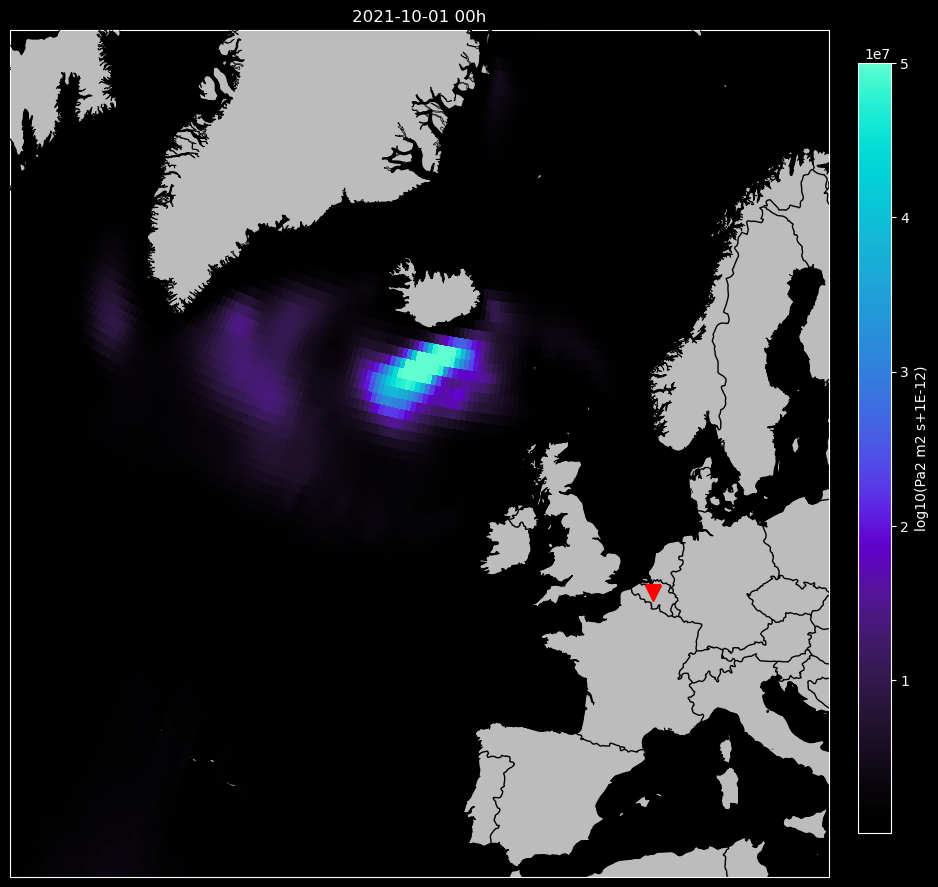

In [24]:
plt.style.use('dark_background')
#cmap = "magma"
cmap = plt.get_cmap('cmr.cosmic')

fig2 = plt.figure(figsize=(13,11))

ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=0.0, central_latitude=50.0))
ax.coastlines("10m", linewidth=0.5, zorder=9, color="k")
quad = plt.pcolormesh(lons, lats, p2ls[0],
             transform=ccrs.PlateCarree(),vmin=1e5, vmax=0.5e8, cmap=cmap)
target_lat = configs.params.station_lat
target_lon = configs.params.station_lon
ax.add_feature(cartopy.feature.LAND, edgecolor='k', facecolor="#bcbcbc", zorder = 2)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='k', facecolor="#bcbcbc", zorder = 2)
ax.plot(target_lon, target_lat, "rv",markersize=12, zorder =10, transform=ccrs.PlateCarree())
ax.set_extent([-40, 15, 35, 75], crs=ccrs.PlateCarree())

cbar_ax = fig2.add_axes([0.85, 0.15, 0.025, 0.7])
cb = fig2.colorbar(quad, cax=cbar_ax)    
cb.set_label("log10(Pa2 m2 s+1E-12)")

title = (UTCDateTime("1990-01-01")+times[0]*86400).strftime("%Y-%m-%d %Hh")
ax.set_title(title, color="w")
plt.tight_layout()
#plt.plot()

In [25]:
anim = animation.FuncAnimation(fig2, animate, interval=100, frames=len(times) - 1)
anim.save(os.path.join(work_dir,'MAPS','euro_map.gif'))
plt.show()